In [2]:
#Loading all required packages
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

import nltk


from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

In [3]:
#Loading the training variants
data_variants= pd.read_csv('training_variants')
#Loading training text dataset
data_text= pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [4]:
data_variants.head()
data_variants.describe()
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [5]:
data_text.info()
data_text.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


,ID
count,3321.000000
mean,1660.000000
std,958.834449
min,0.000000
25%,830.000000
50%,1660.000000
75%,2490.000000
max,3320.000000


In [158]:
data_text.head()

,ID,TEXT
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...


In [7]:
data_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [159]:
data_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
# Now we want to remove all stop words like a, is, an, the,.....
#so we are collectting all of them using the nltk library
stop_words = set(stopwords.words('english'))

In [11]:
def data_text_preprocess(total_text, ind, col):
    #remove the integer values from the data, those might not be that much important
    if type(total_text) is not int:
        string = ""
        #replace all special characters with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        #replace so many spaces from the text file
        total_text = re.sub('\s+',' ', str(total_text))
        #changing whole text to small letters
        total_text = total_text.lower()
        
        for word in total_text.split():
            # if the word is not a stop word like a, an, the,etc..then we will retain that word o/w remove.
            if not word in stop_words:
                string += word + " "
                
        data_text[col][ind] = string

In [12]:
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'], index, 'TEXT')

In [13]:
#merging both the datasets on the basis of ID and create a new data frame
result = pd.merge(data_variants, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [14]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [15]:
#instead of removing the missing values i have decided to impute the values with genes and variatons
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene']+' '+result['Variation']

In [16]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


In [17]:
#Before splitting the dataset we need to be sure that all spaces in gene and variation column were replaced by_.
y_true = result['Class'].values
result.Gene  = result.Gene.str.replace('\s+','_')
result.Variation = result.Variation.str.replace('\s+','_')

In [18]:
#Splitting the data into train and test
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
#Splitting the train data now into train validation and cross validation
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [19]:
print('No. of data points in train data:', train_df.shape[0])
print('No. of data points in test data:', test_df.shape[0])
print('No. of data points in cross-validation data:', cv_df.shape[0])

No. of data points in train data: 2124
No. of data points in test data: 665
No. of data points in cross-validation data: 532


In [144]:
#Distribution of the data
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

In [145]:
train_class_distribution

1    363
2    289
3     57
4    439
5    155
6    176
7    609
8     12
9     24
Name: Class, dtype: int64

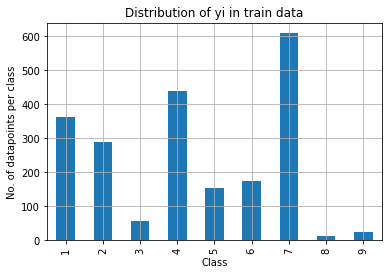

In [146]:
#plotting my training data
my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('No. of datapoints per class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

In [147]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('No. of datapoints in class:',i+1, ':' ,train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100),3), '%)')

No. of datapoints in class: 7 : 609 ( 28.672 %)
No. of datapoints in class: 4 : 439 ( 20.669 %)
No. of datapoints in class: 1 : 363 ( 17.09 %)
No. of datapoints in class: 2 : 289 ( 13.606 %)
No. of datapoints in class: 6 : 176 ( 8.286 %)
No. of datapoints in class: 5 : 155 ( 7.298 %)
No. of datapoints in class: 3 : 57 ( 2.684 %)
No. of datapoints in class: 9 : 24 ( 1.13 %)
No. of datapoints in class: 8 : 12 ( 0.565 %)


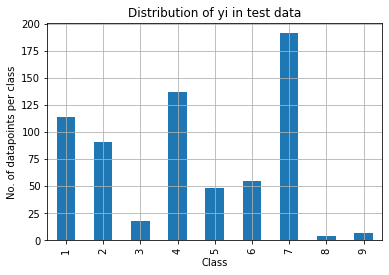

In [151]:
#similarly do it for test dataset
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('No. of datapoints per class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

In [148]:
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('No. of datapoints in class:', i+1, ':' ,test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100),3), '%)')

No. of datapoints in class: 7 : 191 ( 28.722 %)
No. of datapoints in class: 4 : 137 ( 20.602 %)
No. of datapoints in class: 1 : 114 ( 17.143 %)
No. of datapoints in class: 2 : 91 ( 13.684 %)
No. of datapoints in class: 6 : 55 ( 8.271 %)
No. of datapoints in class: 5 : 48 ( 7.218 %)
No. of datapoints in class: 3 : 18 ( 2.707 %)
No. of datapoints in class: 9 : 7 ( 1.053 %)
No. of datapoints in class: 8 : 4 ( 0.602 %)


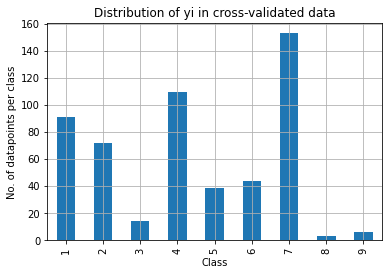

In [149]:
#similarly do it for cross-validated dataset
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('No. of datapoints per class')
plt.title('Distribution of yi in cross-validated data')
plt.grid()
plt.show()

In [150]:
sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('No. of datapoints in class:', i+1, ':' ,cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100),3), '%)')

No. of datapoints in class: 7 : 153 ( 28.759 %)
No. of datapoints in class: 4 : 110 ( 20.677 %)
No. of datapoints in class: 1 : 91 ( 17.105 %)
No. of datapoints in class: 2 : 72 ( 13.534 %)
No. of datapoints in class: 6 : 44 ( 8.271 %)
No. of datapoints in class: 5 : 39 ( 7.331 %)
No. of datapoints in class: 3 : 14 ( 2.632 %)
No. of datapoints in class: 9 : 6 ( 1.128 %)
No. of datapoints in class: 8 : 3 ( 0.564 %)


In [28]:
#Building the random model
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

In [29]:
#  i created a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

Log loss on Cross Validation Data using Random Model 2.5154448925828405


In [30]:
# Test-Set error.
#similarly we done with the cross-valiadted data, now we do with the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))


Log loss on Test Data using Random Model 2.5173691022669473


In [31]:
#Getting the index of max. probab.
predicted_y =np.argmax(test_predicted_y, axis=1)

In [32]:
predicted_y

array([0, 3, 1, 2, 3, 7, 1, 8, 8, 6, 0, 0, 6, 1, 5, 2, 8, 3, 0, 8, 1, 8,
       8, 7, 0, 2, 5, 7, 0, 1, 8, 3, 2, 8, 5, 5, 8, 7, 4, 0, 0, 3, 7, 2,
       0, 8, 3, 2, 7, 4, 6, 4, 7, 6, 1, 3, 0, 6, 6, 3, 2, 2, 6, 2, 0, 1,
       8, 0, 4, 7, 1, 0, 0, 2, 2, 1, 4, 1, 1, 4, 8, 6, 1, 4, 4, 1, 5, 4,
       4, 3, 2, 0, 4, 8, 5, 4, 6, 0, 4, 4, 5, 4, 4, 8, 8, 0, 5, 3, 0, 0,
       2, 8, 6, 6, 1, 5, 4, 7, 5, 3, 2, 8, 0, 3, 1, 4, 8, 8, 6, 3, 7, 7,
       5, 5, 3, 0, 3, 5, 1, 3, 2, 6, 7, 5, 0, 8, 8, 1, 3, 0, 8, 2, 8, 1,
       7, 1, 5, 4, 4, 4, 0, 8, 3, 0, 1, 8, 5, 2, 7, 8, 5, 6, 6, 1, 7, 8,
       8, 8, 3, 8, 2, 1, 6, 2, 5, 2, 6, 6, 5, 3, 8, 1, 3, 6, 6, 6, 5, 3,
       0, 2, 2, 3, 0, 2, 5, 5, 5, 2, 2, 3, 4, 3, 4, 2, 8, 8, 4, 5, 5, 5,
       4, 1, 8, 0, 3, 1, 7, 6, 6, 8, 5, 3, 0, 7, 2, 2, 6, 8, 5, 2, 6, 5,
       8, 6, 6, 6, 8, 7, 6, 5, 0, 3, 7, 2, 5, 4, 0, 4, 6, 2, 2, 1, 0, 3,
       2, 4, 3, 4, 3, 4, 4, 3, 4, 5, 7, 7, 2, 8, 4, 3, 1, 2, 6, 7, 5, 7,
       0, 4, 0, 5, 7, 0, 8, 8, 1, 0, 1, 4, 2, 4, 1,

In [33]:
predicted_y = predicted_y + 1

In [34]:
predicted_y

array([1, 4, 2, 3, 4, 8, 2, 9, 9, 7, 1, 1, 7, 2, 6, 3, 9, 4, 1, 9, 2, 9,
       9, 8, 1, 3, 6, 8, 1, 2, 9, 4, 3, 9, 6, 6, 9, 8, 5, 1, 1, 4, 8, 3,
       1, 9, 4, 3, 8, 5, 7, 5, 8, 7, 2, 4, 1, 7, 7, 4, 3, 3, 7, 3, 1, 2,
       9, 1, 5, 8, 2, 1, 1, 3, 3, 2, 5, 2, 2, 5, 9, 7, 2, 5, 5, 2, 6, 5,
       5, 4, 3, 1, 5, 9, 6, 5, 7, 1, 5, 5, 6, 5, 5, 9, 9, 1, 6, 4, 1, 1,
       3, 9, 7, 7, 2, 6, 5, 8, 6, 4, 3, 9, 1, 4, 2, 5, 9, 9, 7, 4, 8, 8,
       6, 6, 4, 1, 4, 6, 2, 4, 3, 7, 8, 6, 1, 9, 9, 2, 4, 1, 9, 3, 9, 2,
       8, 2, 6, 5, 5, 5, 1, 9, 4, 1, 2, 9, 6, 3, 8, 9, 6, 7, 7, 2, 8, 9,
       9, 9, 4, 9, 3, 2, 7, 3, 6, 3, 7, 7, 6, 4, 9, 2, 4, 7, 7, 7, 6, 4,
       1, 3, 3, 4, 1, 3, 6, 6, 6, 3, 3, 4, 5, 4, 5, 3, 9, 9, 5, 6, 6, 6,
       5, 2, 9, 1, 4, 2, 8, 7, 7, 9, 6, 4, 1, 8, 3, 3, 7, 9, 6, 3, 7, 6,
       9, 7, 7, 7, 9, 8, 7, 6, 1, 4, 8, 3, 6, 5, 1, 5, 7, 3, 3, 2, 1, 4,
       3, 5, 4, 5, 4, 5, 5, 4, 5, 6, 8, 8, 3, 9, 5, 4, 2, 3, 7, 8, 6, 8,
       1, 5, 1, 6, 8, 1, 9, 9, 2, 1, 2, 5, 3, 5, 2,

In [35]:
# Confusion matrix of the random model
C = confusion_matrix(y_test, predicted_y)

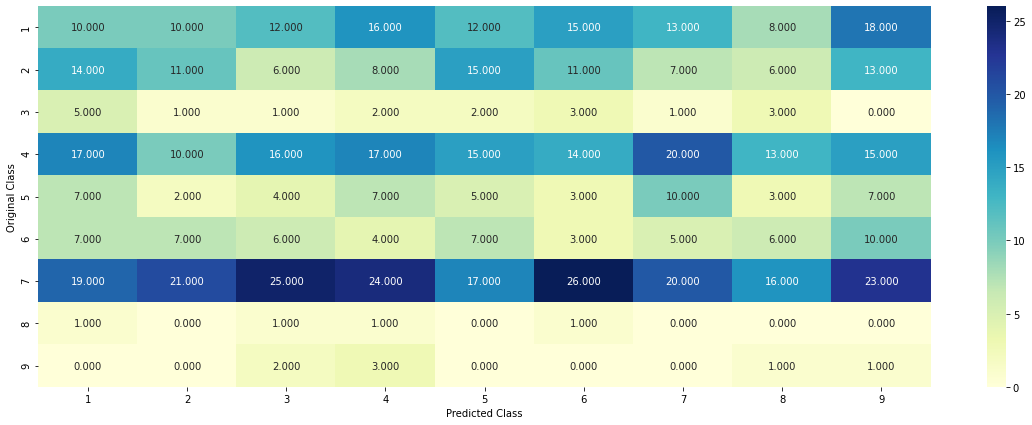

In [36]:
labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [37]:
# Building the precision matrix of the random model
B =(C/C.sum(axis=0))

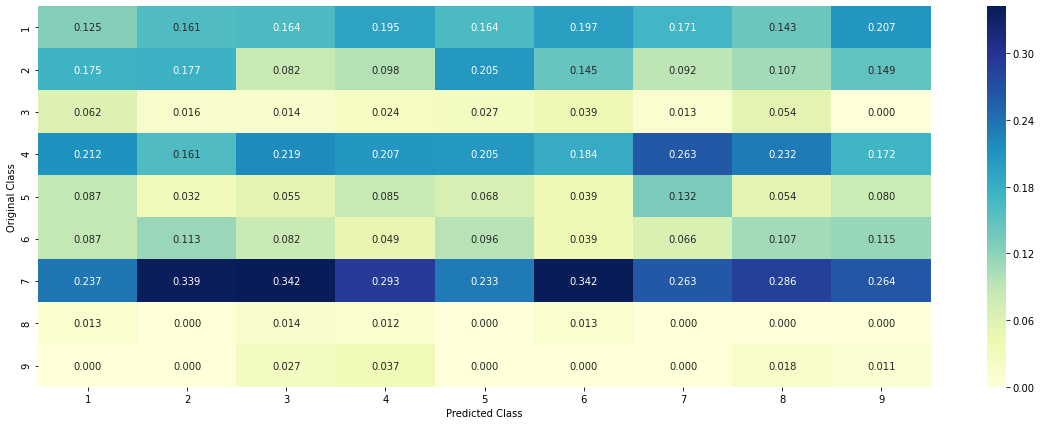

In [38]:
plt.figure(figsize=(20,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [39]:
# Exploring the column which is categorical in nature
unique_genes = train_df['Gene'].value_counts()
print('No. of Unique Genes :', unique_genes.shape[0])
# the most occuring top 10 genes
print(unique_genes.head(10))

No. of Unique Genes : 231
BRCA1     175
TP53      111
EGFR       83
BRCA2      74
PTEN       74
BRAF       64
KIT        54
ERBB2      48
ALK        44
CDKN2A     39
Name: Gene, dtype: int64


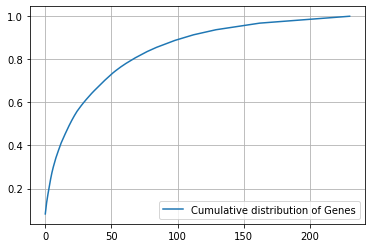

In [40]:
#plotting the cumulative distribution plot for unique gene values
s = sum(unique_genes.values);
h = unique_genes.values/s;
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

In [41]:
# one-hot encoding of Gene column
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [160]:
train_gene_feature_onehotCoding.shape

(2124, 231)

In [43]:
#column names after one-hot encoding for Gene column
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl1',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'axin1',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fat1',
 'fbxw7',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'gata3',
 'gli1',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'ikbke',
 'il7

In [44]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):

    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [45]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [46]:
train_gene_feature_responseCoding.shape

(2124, 9)

In [47]:
#hyperparameter for SGD classifier
alpha = [10 ** x for x in range(-5, 1)]

In [48]:
#using the SGD classifier
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.1979563308352843
For values of alpha =  0.0001 The log loss is: 1.1811476069896882
For values of alpha =  0.001 The log loss is: 1.2229074700627551
For values of alpha =  0.01 The log loss is: 1.3321626928039152
For values of alpha =  0.1 The log loss is: 1.4264241639090944
For values of alpha =  1 The log loss is: 1.4611940166060602


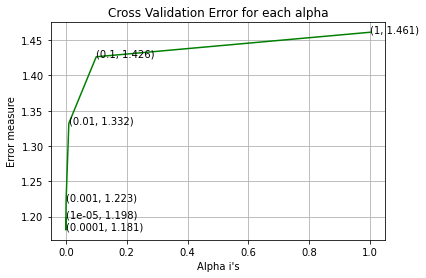

In [49]:
# plotting the same to check the best alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


In [50]:
#using the best alpha value and compute the log loss for all the three datasets i.e., train, test, cv
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.9858931228577057
For values of best alpha =  0.0001 The cross validation log loss is: 1.1811476069896882
For values of best alpha =  0.0001 The test log loss is: 1.1734448573593461


In [51]:
#checking the stability of the model, to check that we need to find that how many values are overlapping(in gene column) in our model
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

In [52]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 637 out of 665 : 95.78947368421052
2. In cross validation data 519 out of  532 : 97.55639097744361


In [53]:
#Now evaluating the variation column in our dataframe i.e., second catagorical column
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1929
Truncating_Mutations    59
Amplification           49
Deletion                47
Fusions                 20
Overexpression           4
G12V                     4
Y42C                     2
Q61R                     2
Q209L                    2
E542K                    2
Name: Variation, dtype: int64


[0.02777778 0.05084746 0.07297552 ... 0.99905838 0.99952919 1.        ]


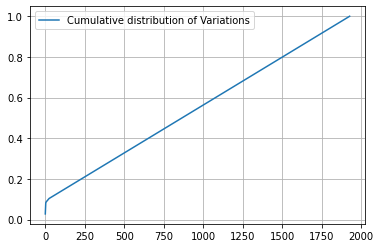

In [54]:
#plotting
s = sum(unique_variations.values);
h = unique_variations.values/s;
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [55]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [56]:
train_variation_feature_onehotCoding.shape

(2124, 1956)

In [57]:
alpha = 1
# train variation feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test variation feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation variation feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [58]:
train_variation_feature_responseCoding.shape

(2124, 9)

In [59]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

In [60]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.7158595361056033
For values of alpha =  0.0001 The log loss is: 1.7153231130993103
For values of alpha =  0.001 The log loss is: 1.7132519523534362
For values of alpha =  0.01 The log loss is: 1.7162607341674758
For values of alpha =  0.1 The log loss is: 1.7214747036655382
For values of alpha =  1 The log loss is: 1.7236606995302963


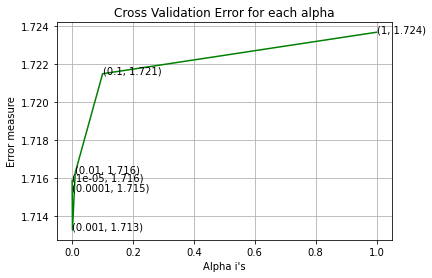

In [61]:
#plotting to check the best alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [62]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 1.0471998926416783
For values of best alpha =  0.001 The cross validation log loss is: 1.7132519523534362
For values of best alpha =  0.001 The test log loss is: 1.700533563455335


In [63]:
#Now, we are going for the text column in our dataframe
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary


In [64]:
import math

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [65]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting the name of the words
train_text_features= text_vectorizer.get_feature_names()

train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 52027


In [66]:
dict_list = []

for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [67]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [68]:
#converting each row value such that they sum to 1
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [69]:
# normalizing every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [70]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [71]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 4552, 4: 3810, 5: 2699, 6: 2379, 8: 2350, 7: 1813, 10: 1724, 9: 1523, 12: 1287, 11: 1089, 13: 1077, 15: 1034, 14: 912, 16: 770, 20: 672, 17: 653, 18: 642, 19: 515, 24: 495, 21: 486, 22: 425, 25: 401, 28: 394, 27: 391, 26: 375, 39: 346, 30: 325, 23: 321, 31: 306, 50: 299, 36: 293, 33: 280, 32: 267, 29: 265, 35: 244, 40: 243, 42: 239, 34: 215, 37: 214, 38: 207, 41: 205, 52: 179, 44: 175, 45: 173, 43: 173, 56: 167, 48: 167, 51: 160, 57: 156, 46: 156, 60: 154, 49: 140, 55: 131, 53: 128, 47: 128, 54: 122, 64: 120, 70: 119, 59: 112, 76: 110, 66: 109, 58: 104, 67: 102, 61: 102, 68: 101, 82: 100, 65: 96, 63: 95, 62: 95, 72: 94, 75: 85, 73: 82, 84: 79, 69: 78, 95: 77, 83: 77, 77: 77, 80: 76, 89: 73, 74: 73, 81: 72, 92: 71, 90: 70, 78: 68, 71: 67, 99: 66, 94: 66, 91: 66, 85: 66, 79: 66, 102: 65, 100: 64, 86: 62, 101: 61, 88: 61, 93: 60, 105: 54, 98: 54, 120: 53, 135: 51, 114: 49, 97: 48, 87: 48, 110: 47, 109: 47, 103: 47, 130: 46, 140: 45, 123: 44, 112: 44, 153: 43, 136: 43, 106: 43,

In [72]:
#Again buiding the same model with only text column
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.2928377434316096
For values of alpha =  0.0001 The log loss is: 1.1683370128240056
For values of alpha =  0.001 The log loss is: 1.1612311977407488
For values of alpha =  0.01 The log loss is: 1.2333591941095192
For values of alpha =  0.1 The log loss is: 1.4538155390439387
For values of alpha =  1 The log loss is: 1.655603156996857


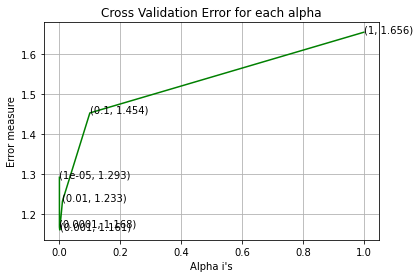

In [73]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [74]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.001 The train log loss is: 0.6452732790231998
For values of best alpha =  0.001 The cross validation log loss is: 1.1612311977407488
For values of best alpha =  0.001 The test log loss is: 1.1607757529399645


In [75]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [76]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.248 % of word of test data appeared in train data
97.377 % of word of Cross Validation appeared in train data


# Data processing

In [77]:
#these are some functions i am going to use in my models
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [78]:
# This function plots the confusion matrices given y_i and y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0)) 
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [79]:
# this function will be used just for naive bayes
# for the given indices i will print the name of the features
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [80]:
#combining all the 3 columns together i.e., gene, variations amd text using hstack function
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [81]:
# Now, printing one-hot encoding features
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 54214)
(number of data points * number of features) in test data =  (665, 54214)
(number of data points * number of features) in cross validation data = (532, 54214)


In [82]:
# printing response encoding features
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


# Building the ML models

In [83]:
# Naive Baye's model
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-05
Log Loss : 1.2843799096931248
for alpha = 0.0001
Log Loss : 1.277781568901721
for alpha = 0.001
Log Loss : 1.2713812924054355
for alpha = 0.1
Log Loss : 1.2504994523197963
for alpha = 1
Log Loss : 1.299685984627123
for alpha = 10
Log Loss : 1.431022049587542
for alpha = 100
Log Loss : 1.4117039648881113
for alpha = 1000
Log Loss : 1.3155470343359177


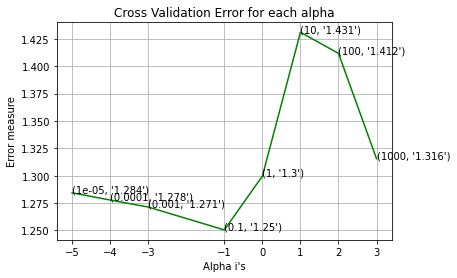

In [84]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [85]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.1 The train log loss is: 0.8626007155404672
For values of best alpha =  0.1 The cross validation log loss is: 1.2504994523197963
For values of best alpha =  0.1 The test log loss is: 1.265159367766629


Log Loss : 1.2504994523197963
Number of missclassified point : 0.39285714285714285
-------------------- Confusion matrix --------------------


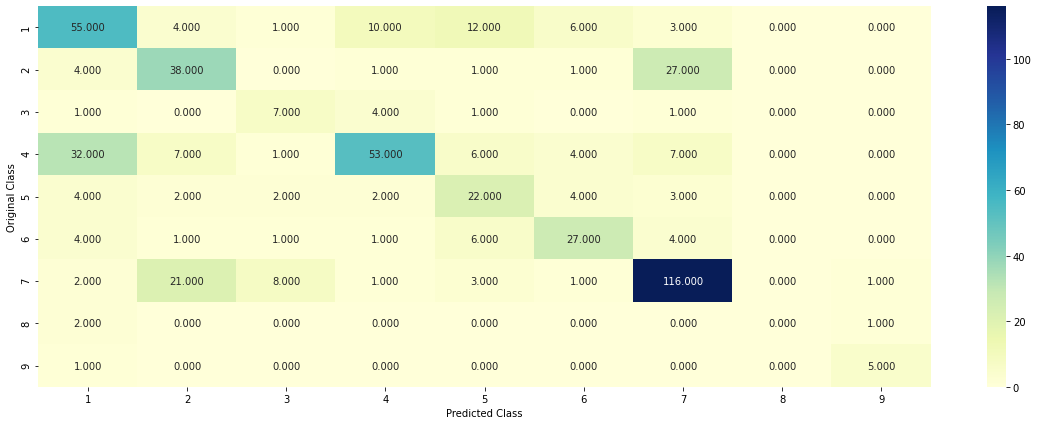

-------------------- Precision matrix (Columm Sum=1) --------------------


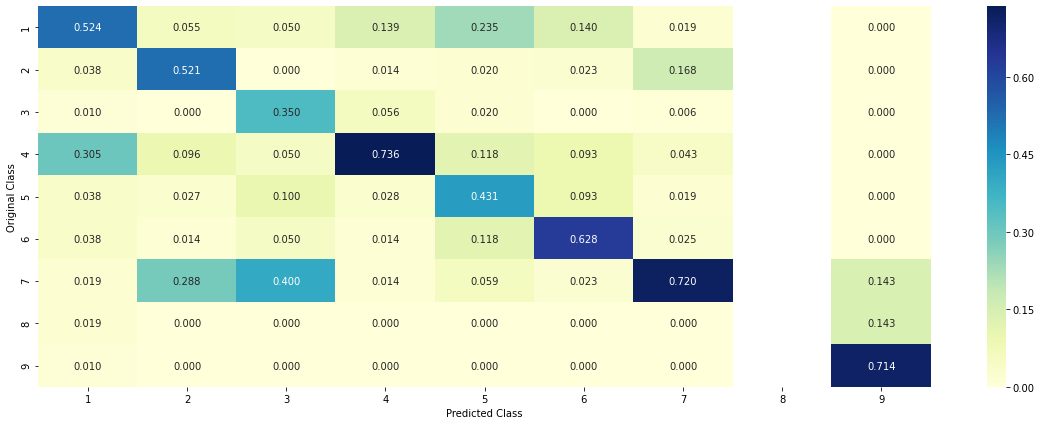

-------------------- Recall matrix (Row sum=1) --------------------


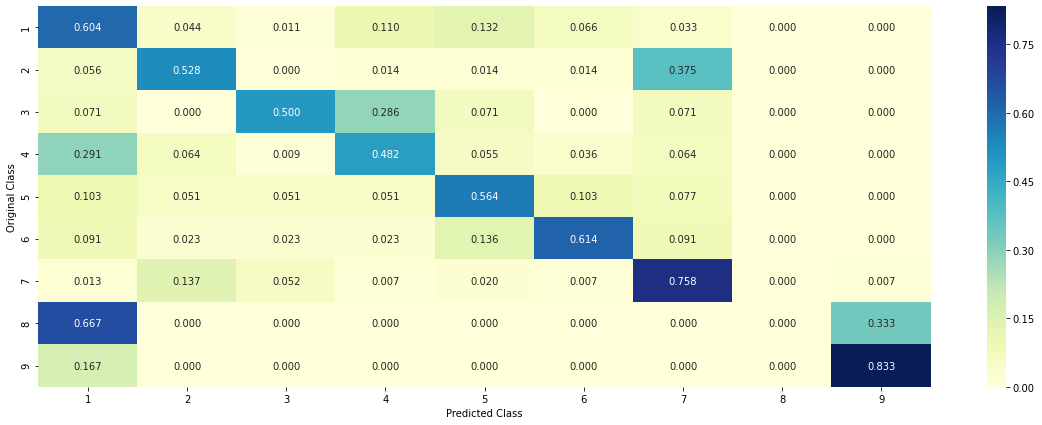

In [86]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [87]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0909 0.5622 0.012  0.1182 0.0383 0.0385 0.1298 0.0063 0.0038]]
Actual Class : 4
--------------------------------------------------
15 Text feature [identified] present in test data point [True]
16 Text feature [molecular] present in test data point [True]
17 Text feature [present] present in test data point [True]
24 Text feature [including] present in test data point [True]
26 Text feature [identification] present in test data point [True]
27 Text feature [novel] present in test data point [True]
28 Text feature [using] present in test data point [True]
29 Text feature [confirmed] present in test data point [True]
30 Text feature [patient] present in test data point [True]
32 Text feature [15] present in test data point [True]
35 Text feature [well] present in test data point [True]
36 Text feature [may] present in test data point [True]
38 Text feature [case] present in test data point [True]
39 Text feature [performed] present i

In [88]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.1887 0.0673 0.0108 0.5406 0.0341 0.034  0.1156 0.0056 0.0034]]
Actual Class : 1
--------------------------------------------------
11 Text feature [protein] present in test data point [True]
14 Text feature [missense] present in test data point [True]
16 Text feature [acid] present in test data point [True]
17 Text feature [activity] present in test data point [True]
18 Text feature [functional] present in test data point [True]
19 Text feature [proteins] present in test data point [True]
22 Text feature [amino] present in test data point [True]
25 Text feature [results] present in test data point [True]
26 Text feature [ability] present in test data point [True]
30 Text feature [type] present in test data point [True]
31 Text feature [whereas] present in test data point [True]
36 Text feature [wild] present in test data point [True]
38 Text feature [stability] present in test data point [True]
39 Text feature [whether] present in 

In [89]:
# KNN- ALGORITHM
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 5
Log Loss : 1.054834124734065
for alpha = 11
Log Loss : 1.0802404214740409
for alpha = 15
Log Loss : 1.0890848876550203
for alpha = 21
Log Loss : 1.1037995828264906
for alpha = 31
Log Loss : 1.1176182713743013
for alpha = 41
Log Loss : 1.1127232788958494
for alpha = 51
Log Loss : 1.1078340604597932
for alpha = 99
Log Loss : 1.1124415901859086


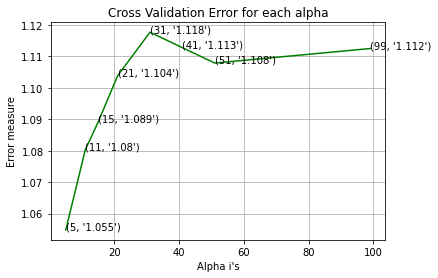

In [90]:
#PLOTTING THE ABOVE ALPHA WITH RELEVANT LOG-LOSS
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [91]:
#for the best alpha log loss of all the 3 dataset
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  5 The train log loss is: 0.45450773280712975
For values of best alpha =  5 The cross validation log loss is: 1.054834124734065
For values of best alpha =  5 The test log loss is: 1.1361661966547982


Log loss : 1.054834124734065
Number of mis-classified points : 0.36278195488721804
-------------------- Confusion matrix --------------------


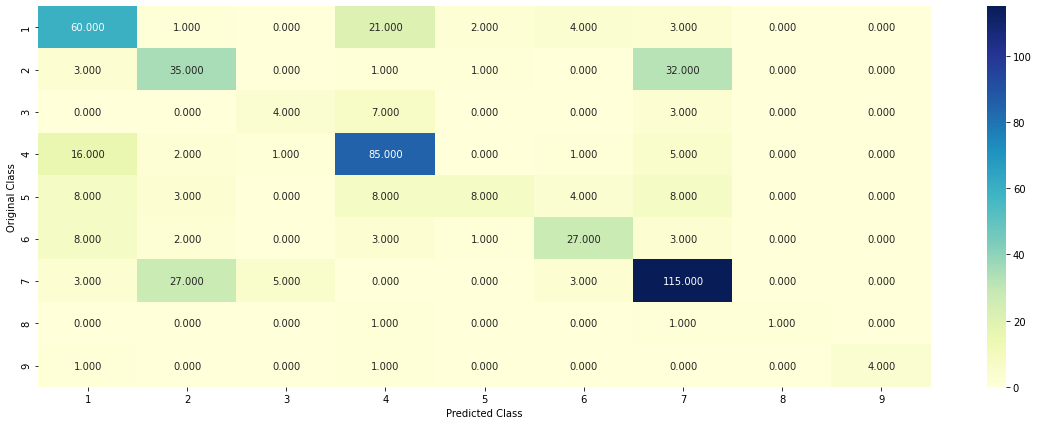

-------------------- Precision matrix (Columm Sum=1) --------------------


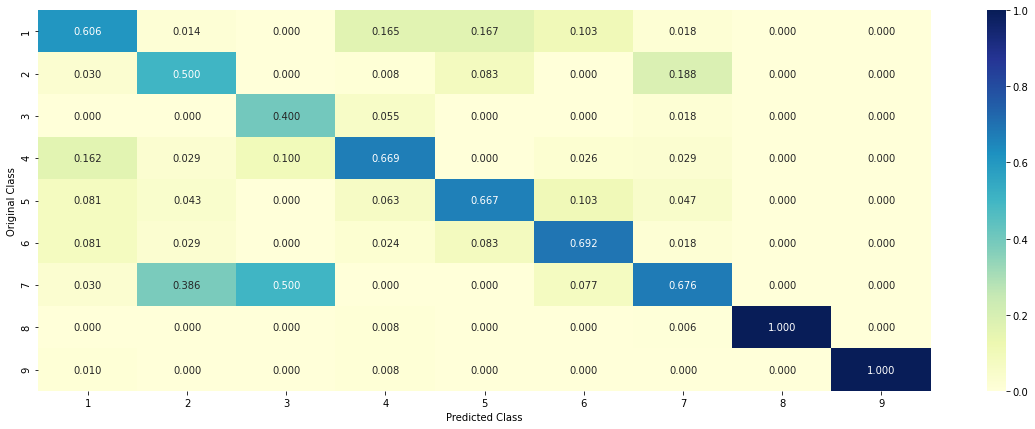

-------------------- Recall matrix (Row sum=1) --------------------


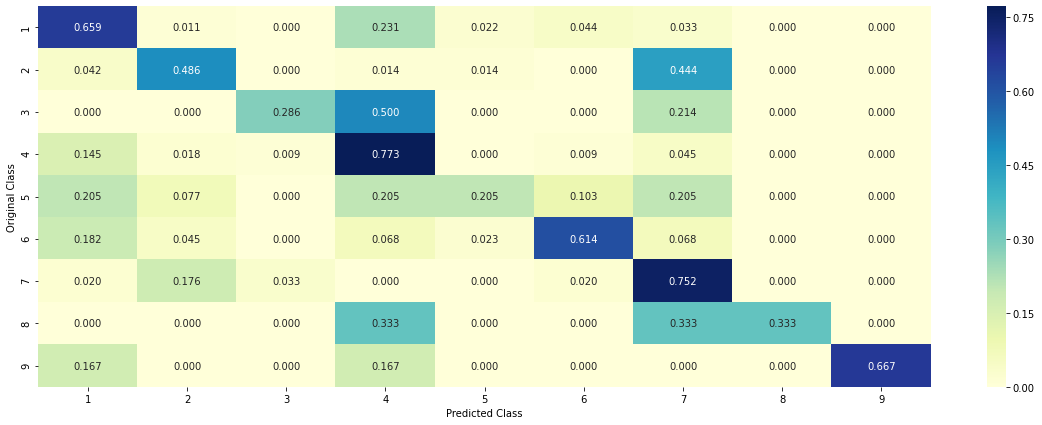

In [92]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [93]:
# Lets look at few test points
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Actual Class :", predicted_cls[0])
print("Predicted Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Actual Class : 5
Predicted Class : 4
The  5  nearest neighbours of the test points belongs to classes [2 8 4 2 2]
Fequency of nearest points : Counter({2: 3, 8: 1, 4: 1})


In [94]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 80

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Actual Class :", predicted_cls[0])
print("Predicted Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Actual Class : 6
Predicted Class : 6
the k value for knn is 5 and the nearest neighbours of the test points belongs to classes [6 6 6 6 6]
Fequency of nearest points : Counter({6: 5})


In [122]:
# Logistic regression with balancing my data
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for alpha = 1e-06
Log Loss : 1.3247637313659408
for alpha = 1e-05
Log Loss : 1.2828463482455024
for alpha = 0.0001
Log Loss : 1.1096914051239748
for alpha = 0.001
Log Loss : 1.10249816746562
for alpha = 0.01
Log Loss : 1.154411273493875
for alpha = 0.1
Log Loss : 1.4488761919474742
for alpha = 1
Log Loss : 1.6622691602379784
for alpha = 10
Log Loss : 1.6906746602523517
for alpha = 100
Log Loss : 1.6938349992817676


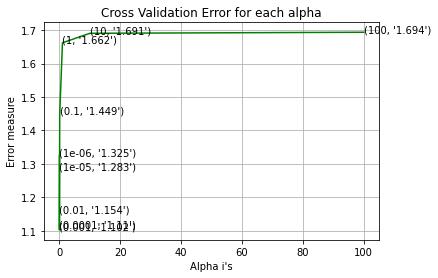

In [123]:
# again plotting the alpha with respect to log-loss
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [124]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5132708693608429
For values of best alpha =  0.001 The cross validation log loss is: 1.10249816746562
For values of best alpha =  0.001 The test log loss is: 1.0725617429162728


Log loss : 1.10249816746562
Number of mis-classified points : 0.34962406015037595
-------------------- Confusion matrix --------------------


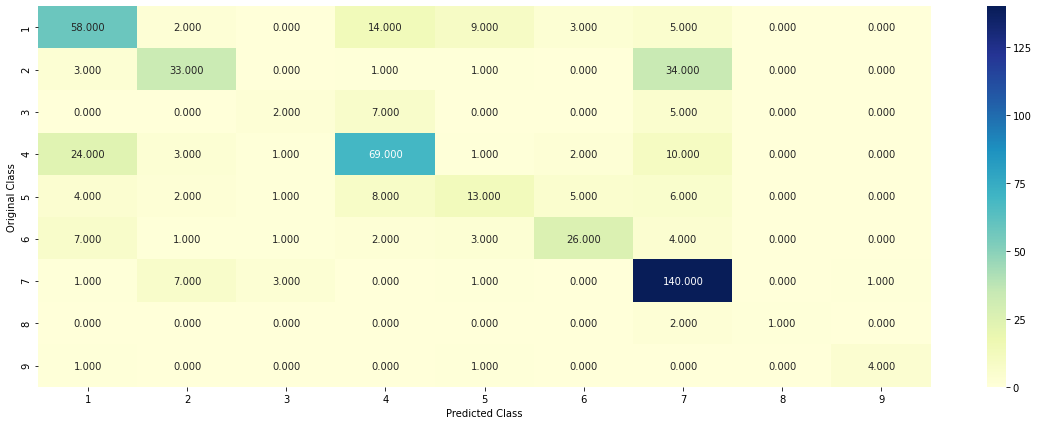

-------------------- Precision matrix (Columm Sum=1) --------------------


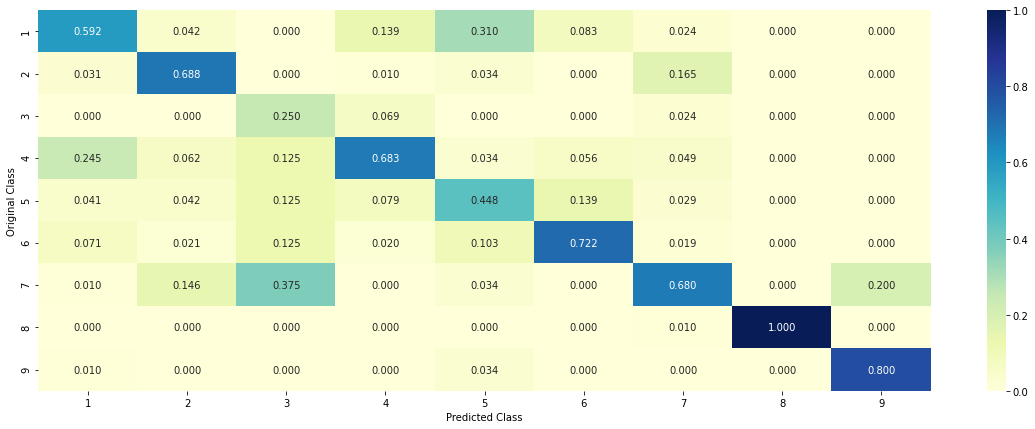

-------------------- Recall matrix (Row sum=1) --------------------


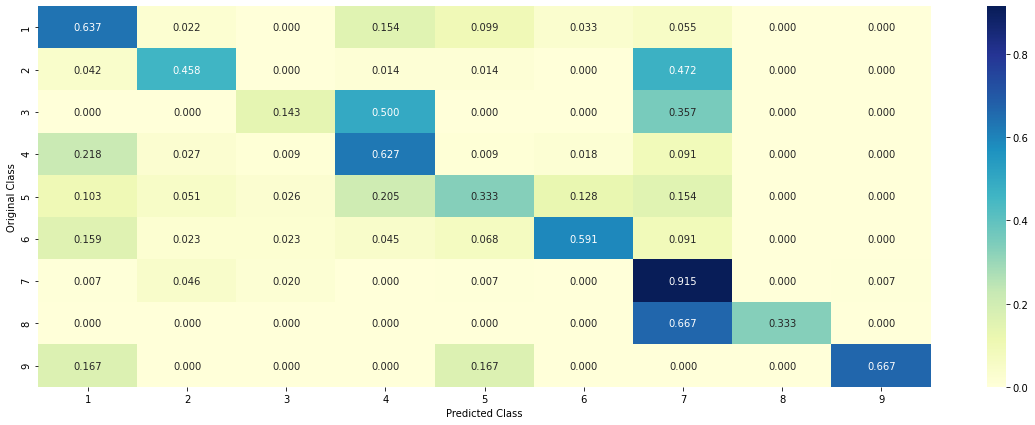

In [125]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [126]:
# defining a function to know the the importance of the feature
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [128]:
from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 5
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 5
Predicted Class Probabilities: [[0.2244 0.0146 0.0214 0.2238 0.4818 0.0175 0.0091 0.0053 0.002 ]]
Actual Class : 1
--------------------------------------------------
227 Text feature [v1833m] present in test data point [True]
383 Text feature [pathogenicity] present in test data point [True]
445 Text feature [probabilities] present in test data point [True]
467 Text feature [unclassified] present in test data point [True]
476 Text feature [kconfab] present in test data point [True]
480 Text feature [likelihood] present in test data point [True]
Out of the top  500  features  6 are present in query point


In [130]:
test_point_index = 50
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.8965 0.0244 0.0044 0.0223 0.0153 0.0097 0.0204 0.0045 0.0024]]
Actual Class : 1
--------------------------------------------------
154 Text feature [homophilic] present in test data point [True]
167 Text feature [neutravidin] present in test data point [True]
183 Text feature [sk18] present in test data point [True]
262 Text feature [pcp2] present in test data point [True]
363 Text feature [mam] present in test data point [True]
471 Text feature [frameshifts] present in test data point [True]
490 Text feature [deletion] present in test data point [True]
Out of the top  500  features  7 are present in query point


In [102]:
# Now, doing the same work we have done above just removing the balancing method from the method column this means it is LR without balancing
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for alpha = 1e-06
Log Loss : 1.2916402837895267
for alpha = 1e-05
Log Loss : 1.2402152001149287
for alpha = 0.0001
Log Loss : 1.127583334056951
for alpha = 0.001
Log Loss : 1.1143910352659776
for alpha = 0.01
Log Loss : 1.1747978222108189
for alpha = 0.1
Log Loss : 1.3529037749875312
for alpha = 1
Log Loss : 1.5948181604090124


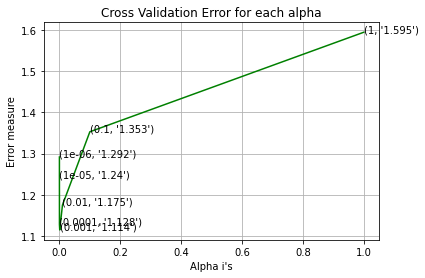

In [103]:
# plotting
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [104]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5160712097700929
For values of best alpha =  0.001 The cross validation log loss is: 1.1143910352659776
For values of best alpha =  0.001 The test log loss is: 1.0915155931611387


Log loss : 1.1143910352659776
Number of mis-classified points : 0.3383458646616541
-------------------- Confusion matrix --------------------


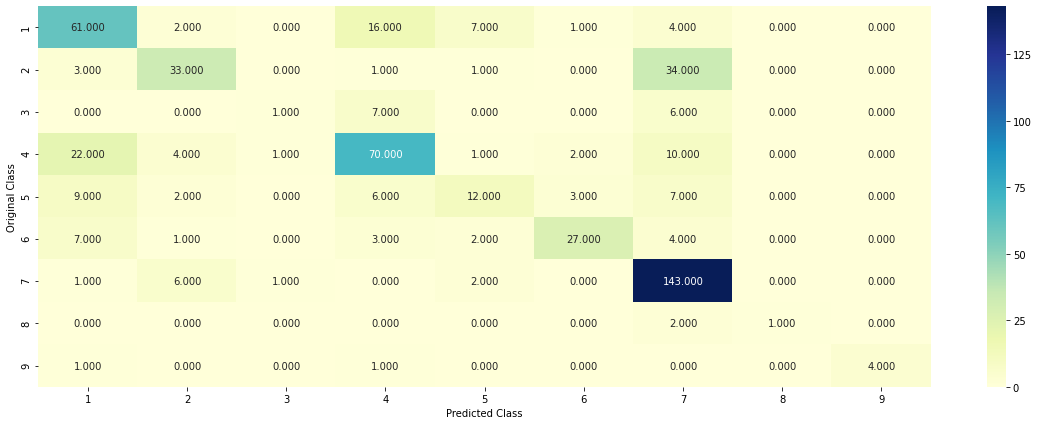

-------------------- Precision matrix (Columm Sum=1) --------------------


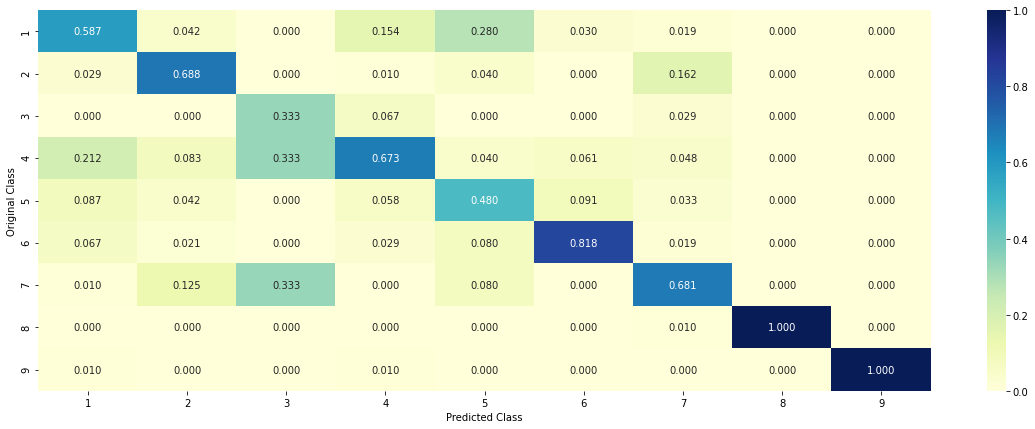

-------------------- Recall matrix (Row sum=1) --------------------


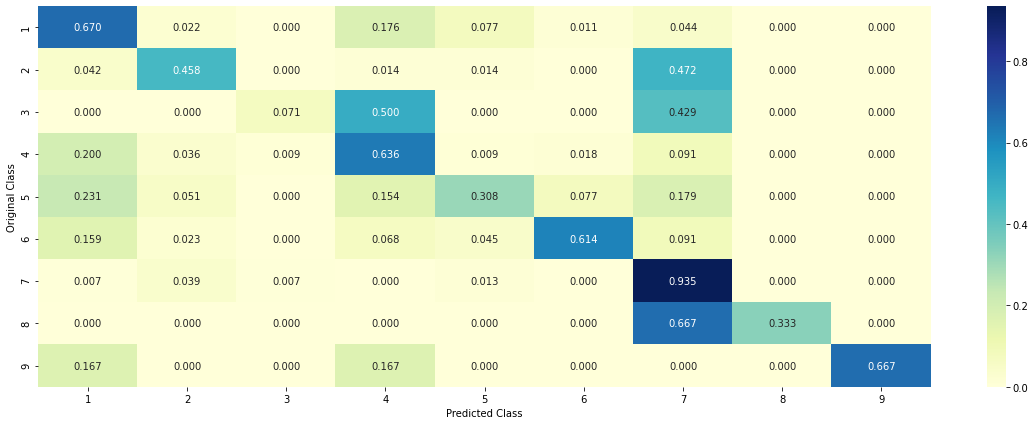

In [105]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [106]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0998 0.6379 0.0025 0.09   0.0148 0.0109 0.1352 0.008  0.0009]]
Actual Class : 4
--------------------------------------------------
347 Text feature [eyelashes] present in test data point [True]
389 Text feature [necessitating] present in test data point [True]
404 Text feature [sagittal] present in test data point [True]
435 Text feature [knee] present in test data point [True]
462 Text feature [roberts] present in test data point [True]
Out of the top  500  features  5 are present in query point


In [131]:
# testing our query points and interpretability of the model
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 80
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[2.300e-03 5.000e-03 3.200e-03 1.076e-01 2.800e-03 8.724e-01 2.200e-03
  3.900e-03 8.000e-04]]
Actual Class : 6
--------------------------------------------------
161 Text feature [s80] present in test data point [True]
201 Text feature [spermatogenesis] present in test data point [True]
244 Text feature [ccdc98] present in test data point [True]
294 Text feature [weakened] present in test data point [True]
326 Text feature [hospitals] present in test data point [True]
345 Text feature [sterility] present in test data point [True]
361 Text feature [zn2] present in test data point [True]
366 Text feature [c44r] present in test data point [True]
367 Text feature [g98r] present in test data point [True]
368 Text feature [c61l] present in test data point [True]
369 Text feature [k45e] present in test data point [True]
370 Text feature [r7c] present in test data point [True]
371 Text feature [l82p] present in test data point [True]
372 Tex

In [153]:
# Randonm Forest with one hot encoding
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for n_estimators = 100 and max depth =  5
Log Loss : 1.247803692220492
for n_estimators = 100 and max depth =  10
Log Loss : 1.1845022270056835
for n_estimators = 200 and max depth =  5
Log Loss : 1.233653803138955
for n_estimators = 200 and max depth =  10
Log Loss : 1.171495635569231
for n_estimators = 500 and max depth =  5
Log Loss : 1.2289548889022142
for n_estimators = 500 and max depth =  10
Log Loss : 1.1697357159989832
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2294501466339343
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1694081524687623
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2296553014389262
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1664581386634412


In [154]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best estimator =  2000 The train log loss is: 0.7085706760504245
For values of best estimator =  2000 The cross validation log loss is: 1.1664581386634412
For values of best estimator =  2000 The test log loss is: 1.1625527980101846


Log loss : 1.1664581386634412
Number of mis-classified points : 0.41541353383458646
-------------------- Confusion matrix --------------------


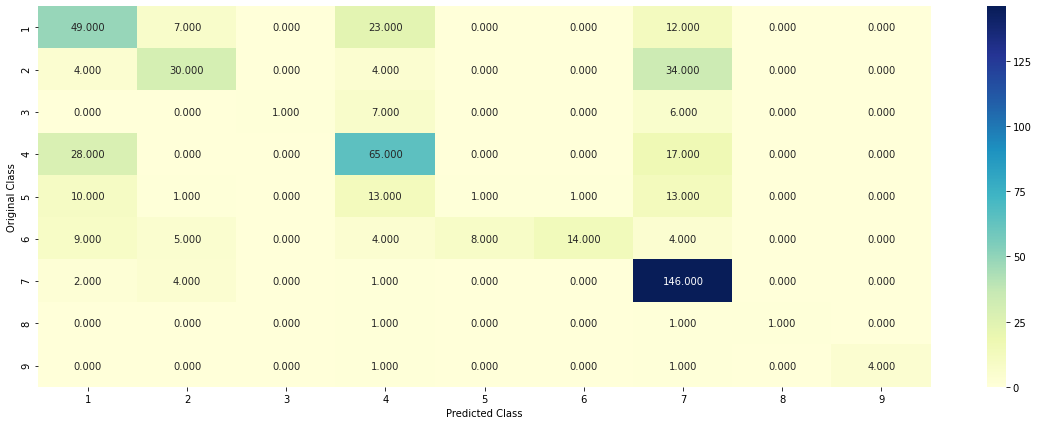

-------------------- Precision matrix (Columm Sum=1) --------------------


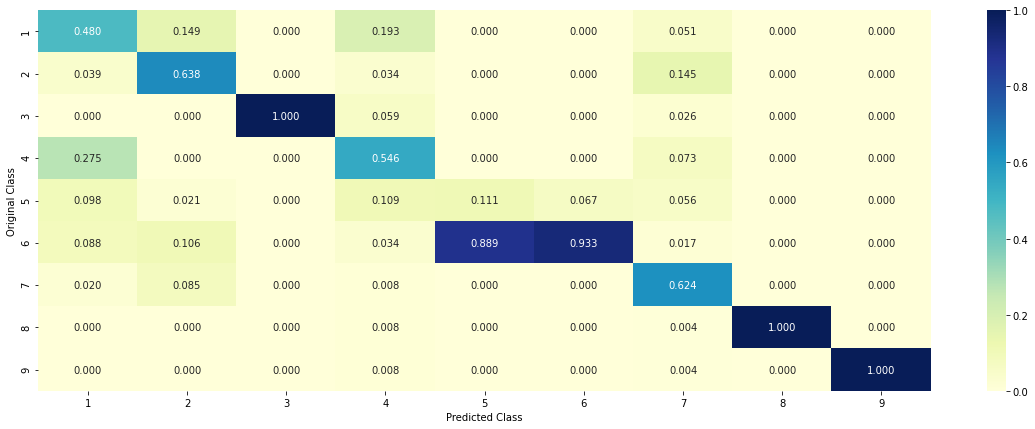

-------------------- Recall matrix (Row sum=1) --------------------


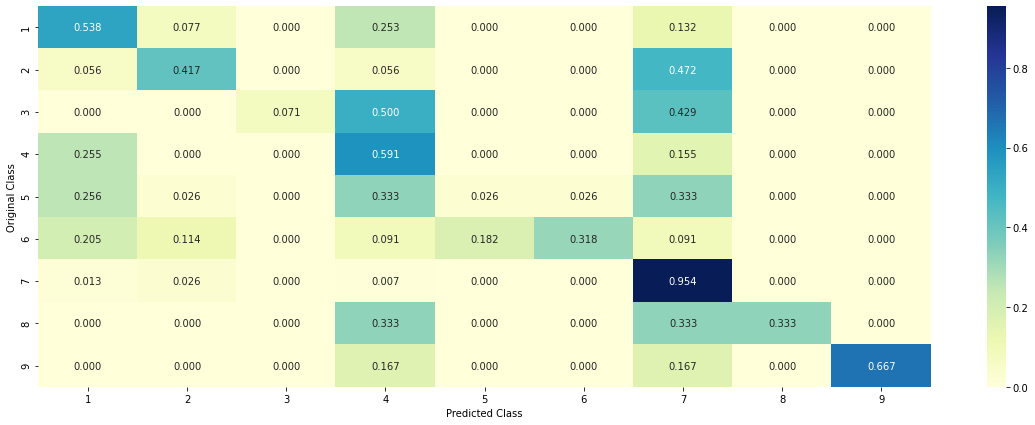

In [155]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [157]:
#test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 25
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.3818 0.1338 0.0253 0.2066 0.0797 0.0799 0.0759 0.0085 0.0084]]
Actual Class : 1
--------------------------------------------------
8 Text feature [treatment] present in test data point [True]
20 Text feature [loss] present in test data point [True]
31 Text feature [cells] present in test data point [True]
40 Text feature [pathogenic] present in test data point [True]
49 Text feature [deleterious] present in test data point [True]
51 Text feature [patients] present in test data point [True]
52 Text feature [variants] present in test data point [True]
60 Text feature [cell] present in test data point [True]
64 Text feature [expression] present in test data point [True]
67 Text feature [variant] present in test data point [True]
68 Text feature [neutral] present in test data point [True]
71 Text feature [unclassified] present in test data point [True]
77 Text feature [repair] present in test data point [True]
78 Text feature [advanced

In [112]:
#Random forest with response encoding
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.077550542176198
for n_estimators = 10 and max depth =  3
Log Loss : 1.587277140041427
for n_estimators = 10 and max depth =  5
Log Loss : 1.3838624937104267
for n_estimators = 10 and max depth =  10
Log Loss : 1.7545698105247023
for n_estimators = 50 and max depth =  2
Log Loss : 1.7060693056233291
for n_estimators = 50 and max depth =  3
Log Loss : 1.446202675141865
for n_estimators = 50 and max depth =  5
Log Loss : 1.3476695171647881
for n_estimators = 50 and max depth =  10
Log Loss : 1.635846748705175
for n_estimators = 100 and max depth =  2
Log Loss : 1.5424847647865376
for n_estimators = 100 and max depth =  3
Log Loss : 1.463691973435371
for n_estimators = 100 and max depth =  5
Log Loss : 1.2955229719356183
for n_estimators = 100 and max depth =  10
Log Loss : 1.6907989596526016
for n_estimators = 200 and max depth =  2
Log Loss : 1.572293392698602
for n_estimators = 200 and max depth =  3
Log Loss : 1.4684247456965966
for

Log loss : 1.2955229719356183
Number of mis-classified points : 0.4266917293233083
-------------------- Confusion matrix --------------------


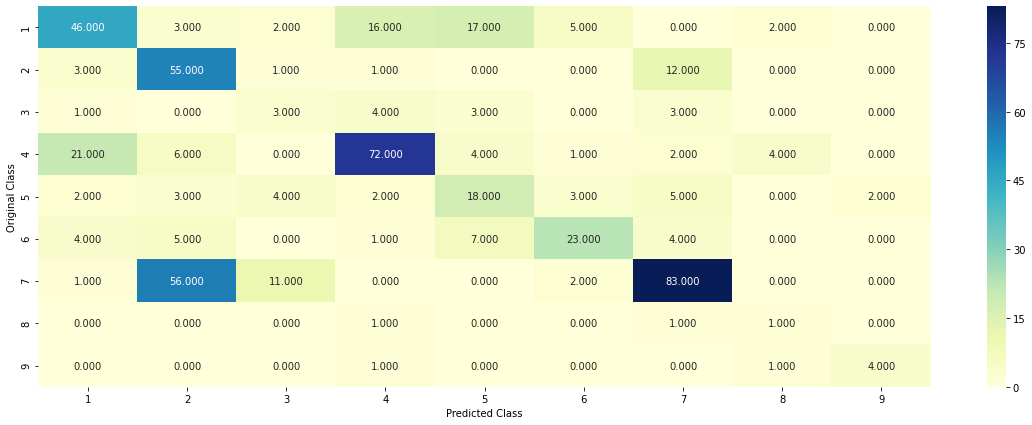

-------------------- Precision matrix (Columm Sum=1) --------------------


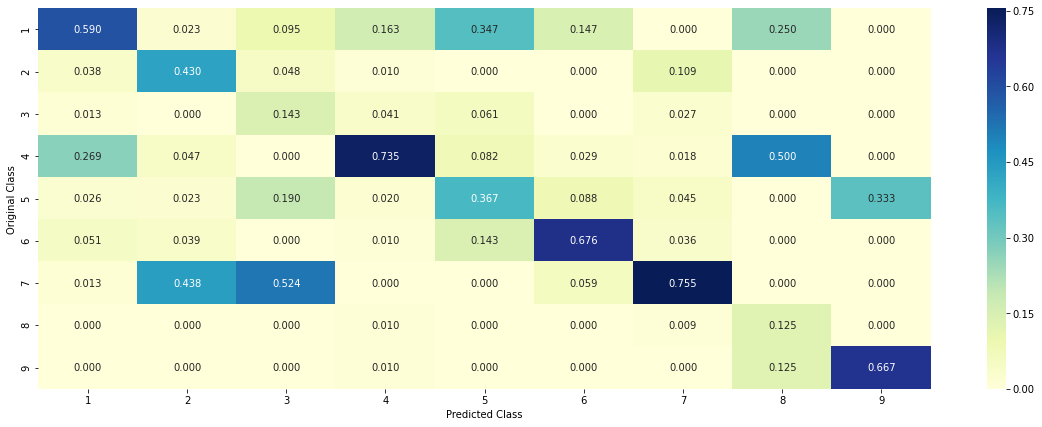

-------------------- Recall matrix (Row sum=1) --------------------


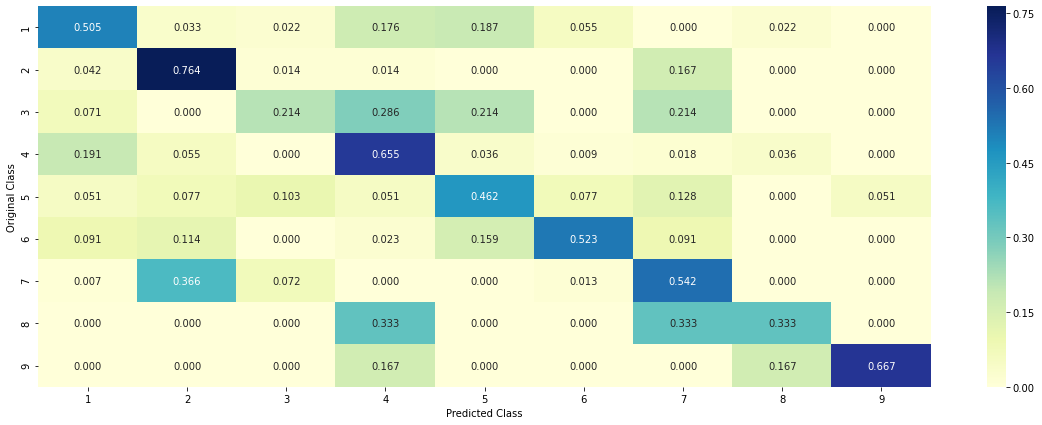

In [113]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

In [114]:
#querying the claasified points
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 8
Predicted Class Probabilities: [[0.0507 0.2081 0.0805 0.0534 0.0402 0.0604 0.0288 0.3462 0.1318]]
Actual Class : 4
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Gene is important feature
